In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import seaborn as sns

## Compute matches

In [2]:
def compute_matches(dir_path, mode, epoch, body_part, hope=False, print_output=True):
    labels_df = pd.read_csv(fr"{dir_path}/files/saved_preds/{mode}_labels.csv")
    preds_df = pd.read_csv(fr"{dir_path}/files/saved_preds/{mode}_preds.csv")
    
    if mode == 'val':
        wanted_labels_keys = list(labels_df.filter(regex=body_part).filter(regex='val').keys())
        wanted_preds_keys = list(preds_df.filter(regex=body_part).filter(regex='val').keys())
    else:
        wanted_labels_keys = list(labels_df.filter(regex=body_part).keys())
        wanted_preds_keys = list(preds_df.filter(regex=body_part).keys())

    temp = labels_df[wanted_labels_keys]
    labels_df = pd.DataFrame(temp.iloc[epoch]).rename(columns={epoch: 'Labels'})

    temp = preds_df[wanted_preds_keys]
    preds_df = pd.DataFrame(temp.iloc[epoch]).rename(columns={epoch: 'Preds'})
    
    num = 3.0
    if hope:
        num = 4.0
    
    concat_df = pd.concat([labels_df, preds_df], axis=1)
    concat_df['Rounded preds'] = np.round(concat_df['Preds'])
    concat_df['Ceiled']=concat_df['Rounded preds'].apply(lambda x: num if x > num else (0 if x < 0 else x))
    concat_df['Diff'] = np.absolute(concat_df['Ceiled'] - concat_df['Labels'])
    
    if print_output:
        print(concat_df['Diff'].value_counts())
    
    return concat_df
    
    

In [3]:
def separate_train_results(dir_path, mode, epoch, body_part, print_output=True):

    # gets the index values for the OG train dataset
    index_df = compute_matches(r"/home/pedke/multi-task-learning/wandb/run-20230910_154428-huyqycnd", 'train', 1, body_part, print_output)
    index_df.reset_index(inplace=True)
    index_df.drop(['Labels', 'Preds', 'Rounded preds','Ceiled', 'Diff'], axis = 1, inplace = True)
    
    concat_df2 = compute_matches(dir_path, mode, epoch, body_part, print_output)
    concat_df2.reset_index(inplace=True)
    
    interim_df = index_df.merge(concat_df2, on='index', how='left', indicator=True)
    
    print(interim_df['Diff'].value_counts())
    
    return interim_df

In [4]:
def plot_category_answer_distribution(concat_df, category=0.0):
    temp=concat_df.loc[concat_df['Diff'] == category]['Labels'].value_counts().sort_index()
    index_list = [i + 1 for i in list(temp.index)]
    values_list = list(temp.values)

    missing_indicies = list(set([1, 2, 3, 4]).difference(index_list))

    index_list.extend(missing_indicies)
    values_list.extend([0]*len(missing_indicies))

    final = []
    for item in zip(index_list, values_list):
        print(item)
        final.append(list(item))
        
    final_df = pd.DataFrame(final, columns=['Labels', 'Count'], index=None)
    final_df = final_df.set_index('Labels').sort_index()
    final_df
    
    final_df.plot.bar()
    

In [5]:
['Position of meatus', 'Shape of meatus', 'Shape of glans', 'Shape of skin', 'Torsion']

['Position of meatus',
 'Shape of meatus',
 'Shape of glans',
 'Shape of skin',
 'Torsion']

(2, 47)
(3, 59)
(1, 0)
(4, 0)


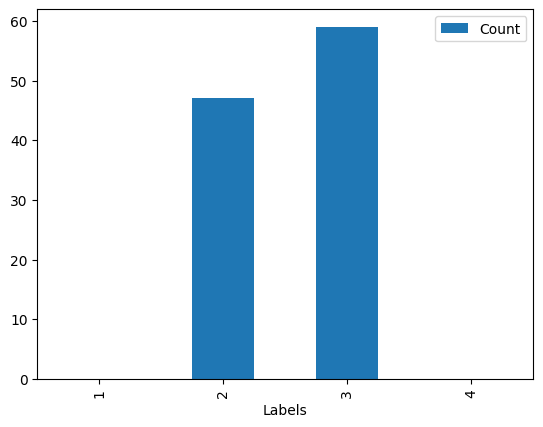

In [10]:
plot_category_answer_distribution(concat_df, category=0.0)

In [ ]:
# To separate OG train ds values
dir_path = r"/home/pedke/multi-task-learning/wandb/run-20231017_135940-5jfxdgnu"
mode = 'train'
epoch = 39
body_part = 'Shaft'

concat_df = separate_train_results(dir_path, mode, epoch, body_part, print_output=False)

## Confusion matrix

In [27]:
concat_df

,Labels,Preds,Rounded preds,Ceiled,Diff
_1160085-Meatus,3,1.700672,2.0,2.0,1.0
DSCF3536-Meatus,2,2.048589,2.0,2.0,0.0
camara dic 10 de 2013 018-Meatus,1,1.800366,2.0,2.0,1.0
IMG_4332-Meatus,2,1.249563,1.0,1.0,1.0
DSCF3148-Meatus,2,1.581763,2.0,2.0,0.0
...,...,...,...,...,...
"Photo 2015-11-23, 8 24 53 AM-Meatus",3,1.375016,1.0,1.0,2.0
b17-Meatus,1,1.652107,2.0,2.0,1.0
"Photo 2017-06-05, 10 36 04-Meatus",2,1.933215,2.0,2.0,0.0
DSCN2287-Meatus,0,1.307162,1.0,1.0,1.0


In [5]:
import torch

def generate_multiclass_confusion_matrix(concat_df):
    smaller_concat_df = concat_df[['Ceiled', 'Labels']]
    matrix = torch.zeros((4, 4))
    
    for i in range(4):
        for j in range(4):
            num_rows = smaller_concat_df.loc[(smaller_concat_df['Labels'] == i) & (smaller_concat_df['Ceiled'] == j)].shape[0]
            matrix[i][j] = num_rows
            
            if j == 0:
                print(f'Label {i}: {smaller_concat_df.loc[smaller_concat_df["Labels"] == i].shape[0]}')
            
    return matrix
    

/home/pedke/multi-task-learning/pedke-venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# General method
dir_path = r"/home/pedke/multi-task-learning/wandb/run-20231107_141351-b0cga62n"
mode = 'val'
epoch =35
body_part = 'Glans'

concat_df = compute_matches(dir_path, mode, epoch, body_part, hope=False)
generate_multiclass_confusion_matrix(concat_df=concat_df)

Diff
1.0    21
0.0    15
2.0    13
3.0     1
Name: count, dtype: int64
Label 0: 8
Label 1: 14
Label 2: 19
Label 3: 9


tensor([[1., 4., 2., 1.],
        [3., 6., 5., 0.],
        [2., 8., 8., 1.],
        [0., 9., 0., 0.]])

In [15]:
concat_df[concat_df['Rounded preds']>3]

,Labels,Preds,Rounded preds,Ceiled,Diff
val_DSC04054-Glans,2,5.983693,6.0,3.0,1.0
val_DSC00131-Glans,2,3.747484,4.0,3.0,1.0


In [305]:
concat_df[(concat_df['Rounded preds']<0) & (concat_df['Labels'] == 4)]

,Labels,Preds,Rounded preds,Ceiled,Diff


In [306]:
concat_df[concat_df['Labels'] == 3]

,Labels,Preds,Rounded preds,Ceiled,Diff
"val_Photo 2015-09-03, 8 25 57 AM-Meatus",3,1.931736,2.0,2.0,1.0
val_DSC00723-Meatus,3,1.731724,2.0,2.0,1.0
val_DSC02086-Meatus,3,5.569457,6.0,3.0,0.0
val_DSC07609-Meatus,3,4.382355,4.0,3.0,0.0
val_DSC00131-Meatus,3,2.466537,2.0,2.0,1.0
val_Penoscrotal with bad plate-Meatus,3,1.809249,2.0,2.0,1.0
val_DSC04054-Meatus,3,1.913266,2.0,2.0,1.0
val_DSC03990-Meatus,3,1.821620,2.0,2.0,1.0
val_P1080221-Meatus,3,1.720515,2.0,2.0,1.0
val_Harris poor plate2-Meatus,3,1.368708,1.0,1.0,2.0
